# - Experimental optical emulator

Author: M. Morgado (morgadovargas@unistra.fr)

August 2021 


<div class="alert alert-block alert-success">

**Goal** : charaterize dynamical optical components and driven pulses for quantum gates and qubit state preparation, considering hardware-aware characterization via transfer matrices, possible future class of AQiPT
    

In [1]:
#libs
%matplotlib inline
import matplotlib.pyplot as plt
from numba import njit
import numpy as np
from scipy import signal, interpolate
import scipy as scp

import AQiPTbeta as aqipt

# import sys
# sys.path.append("/QG8Python/qg8/") # go to parent dir
# from qg8 import *

<img src="resources/opt_setup.png">

<div class="alert alert-block alert-info">

**Class** : class of optical setup, beam path and optical elements
    

In [2]:
class optElement(object):
    
    def __init__(self, args):
        self.args=args
        self.type=None
        self.name=None
        self.label=None
        
    def get_matrix(cls):
        return cls.transferMatrix
    
    def get_name(self):
        return self.name
    
class medium(optElement):
    
    def __init__(self, args):
        optElement.__init__(self, args)
        self.type = 'Passive'
        self.name = 'Medium'
        self.label = args['label']
        self.transferMatrix = np.array([[1 , args['distance']],
                                       [0 , 1]])    
class flatInterface(optElement):
    
    def __init__(self, args):
        self.type = 'Passive'
        self.name = 'Flat Interface'
        self.label = args['label']
        self.transferMatrix = np.array([[1 , 0],
                                        [0 , args['n1']/args['n2']]])
class curvedInterface(optElement):
    
    def __init__(self, args):
        self.type = 'Passive'
        self.name = 'Curved Interface'
        self.label = args['label']
        self.transferMatrix = np.array([[1 , 0],
                                        [((args['n1']-args['n2'])/(args['curvature_radius']*args['n2'])) , args['n1']/args['n2']]])    
class flatMirror(optElement):
    
    def __init__(self, args):
        self.type = 'Passive'
        self.name = 'Flat Mirror'
        self.label = args['label']
        self.transferMatrix = np.array([[1 , 0],
                                        [0 , 1]])
class curvedMirror(optElement):
        
    def __init__(self, args):
        self.type = 'Passive'
        self.name = 'Flat Interface'
        self.label = args['label']
        self.transferMatrix = np.array([[1 , 0],
                                        [-1*(2/args['curvature_radius']) , args['n1']/args['n2']]])
class thinLens(optElement):
    
    def __init__(self, args):
        self.type = 'Passive'
        self.name = 'Flat Interface'
        self.label = args['label']
        self.transferMatrix = np.array([[1 , 0],
                                        [(-1/args['focal_lenght']) , 1]])
class thickLens(optElement):
        
    def __init__(self, args):
        A = np.array([[1 , 0],
                  [((args['n1']-args['n2'])/(args['curvature_radius']*args['n2'])) , args['n1']/args['n2']]])
        B = np.array([[1, args['thickness_center']], [0,1]])
        
        self.type = 'Passive'
        self.name = 'Thick Lens'
        self.label = args['label']
        self.transferMatrix = np.dot(A,np.dot(B,A))        
class prism(optElement):
    
    def __init__(self, args):
        self.type = 'Passive'
        self.name = 'Prism'
        self.label = args['label']
        self.transferMatrix = np.array([[args['beam_expansion'] , args['prism_path_length']/(args['n1']*args['beam_expansion'])],
                                    [0 , 1/args['beam_expansion']]])
class multiplePrism(optElement):
    
    def __init__(self, args):
        self.type = 'Passive'
        self.name = 'Prism'
        self.label = args['label']
        self.transferMatrix = np.array([[args['magnification'],args['total_opt_propagation']],
                                        [0, 1/args['magnification']]])

        
class beam(object):
    
    def __init__(self, amplitude, frequency, polarization, direction, phase=0, aligned=True, tSampling=np.linspace(0,1,100)):
        if aligned==True:
            self.tSamp=tSampling;
            self.amp=amplitude;
            self.freq=frequency;
            self.pol=polarization;
            self.dir=direction;
            self.ph=phase;
            self._Efield=self.amp*np.cos(self.freq*self.tSamp + self.ph)*self.pol;
            self._beamVector=[self._Efield, self.dir];
            self.path=np.array([[1,0],[0,1]]);
            self._elements=list();
        else:
            print('Spacial dependency of setup no supported yet. Sorry :(')
    
    @classmethod
    def create(cls, amplitude, frequency, polarization, direction, phase=0, aligned=True, tSampling=np.linspace(0,1,100)):
        return cls(amplitude, frequency, polarization, direction, phase=0, aligned=True, tSampling=np.linspace(0,1,100))
        
    def add2Path(self, optElmnt):
        if isinstance(optElmnt, object):
            self.path=np.dot(self.path,optElmnt.get_matrix())
            self._elements.append(optElmnt)
        if isinstance(optElmnt, list):
            for element in optElmnt:
                self.path=np.dot(self.path,element.get_matrix())
            self._elements+=optElmnt
    
    def get_beamVector(self):
        return self._beamVector
    
    def get_Efield(self):
        return self._Efield
    
    def get_pathMatrix(self):
        return self.path
    
    def get_elements(self):
        return self._elements

    
    
class OptSetup(object):
    
    def __init__(self):
        self.name=None
        self._beams=list()
        self._elements=list()
    
    def add2Setup(self, newBeam):
        self._beams.append(newBeam)
        self._elements+= newBeam._elements
    
    def _addElements(self, elements):
        if isinstance(elements, optElement):
            self._elements.append(elements)
        if isinstance(elements, list):
            for element in elements:
                if isinstance(element, optElement):
                    self._elements.append(element)
    
    def getbeams(self):
        return self._beams
    
#     def playStatic():
    
#     def playDynamic():

In [3]:
#creating optical elements
optElements_args = {'distance': 1, 'n1': 1, 'n2': 3/4,
                    'curvature_radius': 0.1, 'focal_lenght': 0.05,
                   'thickness_center': 0.1, 'beam_expansion': 1,
                   'prism_path_length': 0.3, 'magnification': 1,
                   'total_opt_propagation': 1, 'label': 'default'}
##mirrors
mirror_1 = flatMirror(optElements_args)
mirror_2 = flatMirror(optElements_args)
mirror_3 = flatMirror(optElements_args)
mirror_4 = flatMirror(optElements_args)
##lenses
lens_1 = thinLens(optElements_args)
lens_2 = thinLens(optElements_args)
##polarizers
# polarizer_1 = polarizer(optElements_args)
# polarizer_2 = polarizer(optElements_args)
##PBC
# pbc = pbc(optElements_args)
##BS
# bs = bs(optElements_args)
##AOM
# aom = aom(optElements_args)
##LASER
# laser = laser(optElements_args)



#creating optical path
OptPath = beam.create(1, 100, +1, [0,0])
##adding optical elements to path
# OptPath.add2Path(laser)
# OptPath.add2Path(polarizer_1)
# OptPath.add2Path(pbc)
OptPath.add2Path(mirror_1)
OptPath.add2Path(mirror_3)

OptPath.add2Path(lens_1)
# OptPath.add2Path(aom)
OptPath.add2Path(lens_2)
# OptPath.add2Path(polarizer_2)
OptPath.add2Path(mirror_4)

OptPath.add2Path(mirror_2)
# OptPath.add2Path(bs)


#creating setup
# optset = aqipt.OptSetup()
##adding optical path
# optset.add2Setup(OptPath)
##calculating matrix
# Experiment = optset.playStatic()





In [ ]:
#creating optical aqipt elements
optElements_args = {'distance': 1, 'n1': 1, 'n2': 3/4,
                    'curvature_radius': 0.1, 'focal_lenght': 0.05,
                   'thickness_center': 0.1, 'beam_expansion': 1,
                   'prism_path_length': 0.3, 'magnification': 1,
                   'total_opt_propagation': 1}
##mirrors
mirror_1 = aqipt.optElement(optElements_args).mirror()
mirror_2 = aqipt.optElement(optElements_args).mirror()
mirror_3 = aqipt.optElement(optElements_args).mirror()
mirror_4 = aqipt.optElement(optElements_args).mirror()
##lenses
lens_1 = aqipt.optElement(optElements_args).lens()
lens_2 = aqipt.optElement(optElements_args).lens()
##polarizers
polarizer_1 = aqipt.optElement(optElements_args).polarizer()
polarizer_2 = aqipt.optElement(optElements_args).polarizer()
##PBC
pbc = aqipt.optElement(optElements_args).pbc()
##BS
bs = aqipt.optElement(optElements_args).bs()
##AOM
aom = aqipt.optElement(optElements_args).aom()
##LASER
laser = aqipt.optElement(optElements_args).laser()



#creating optical path
OptPath = aqipt.beam(amplitude, frequency, polarization, direction).create()
##adding optical elements to path
OptPath.add2Path(laser)
OptPath.add2Path(polarizer_1)
OptPath.add2Path(pbc)
OptPath.add2Path(mirror_1)
OptPath.add2Path(mirror_3)

OptPath.add2Path(lens_1)
OptPath.add2Path(aom)
OptPath.add2Path(lens_2)
OptPath.add2Path(polarizer_2)
OptPath.add2Path(mirror_4)

OptPath.add2Path(mirror_2)
OptPath.add2Path(bs)


#creating setup
# optset = aqipt.OptSetup()
##adding optical path
# optset.add2Setup(OptPath)
##calculating matrix
# Experiment = optset.playStatic()





<div class="alert alert-block alert-info">

**Method** : transfer matrix approach
    
    Note: miss the fact that cross-parameters correlations/effects


In [2]:
#definition of full transfer tensors analysis

@njit
def convolution1D(function, kernel):
    
    n_func = function.size 
    n_ker = kernel.size 
    n_conv = n_func - n_ker + 1 
    
    inv_kernel = kernel[::-1].copy() 
    result = np.zeros(n_conv) 
    
    for i_conv in range(n_conv):
        result[i_conv] = np.dot(function[i_conv: i_conv + n_ker], inv_kernel)
    
    return result*(1/n_ker)



In [3]:
#definition of functions for kernels

#Gaussian function
def gaussian(tau, mu, sig):
    return np.exp(-np.power(tau - mu, 2.) / (2 * np.power(sig, 2.)))

#Gaussian spectral response function
def gaussianSpectralResponse(tau, bw, wa, wl, shift=0):
    return np.exp(-(((tau-shift)**2)*(bw*np.log(2))/(np.pi**2))) * np.exp(-1j*wa*(tau-shift))

#Voigt function
def faddeeva(z):
    m = np.exp(-z**2)
    return (m - m * scp.special.erf(-1.j * z))
def voigt(tau, sigma, gamma, shift=0):
    z = (tau-shift + 1.j * gamma) / (np.sqrt(2.) * sigma)
    return faddeeva(z).real / (sigma * np.sqrt(2 * np.pi))

#Dirac delta function
def diracDelta(tau, idxVal):
    return signal.unit_impulse(int(len(tau)), idxVal)


In [4]:
#kernels

#domaing values for convolution
tau = [np.linspace(0,1,303), np.linspace(0,1,201), np.linspace(0,1,301)]

#functions for kernels k(t)
kernel_1 = diracDelta(tau[0], int(len(tau[0])/2))
kernel_2 = gaussian(tau[0], mu=0.5, sig=0.1) 
kernel_3 = gaussianSpectralResponse(tau[0], bw=200, wa=50, wl=10, shift=0.4)
kernel_4 = voigt(tau[0], sigma=0.1, gamma=0.1, shift=0.4)

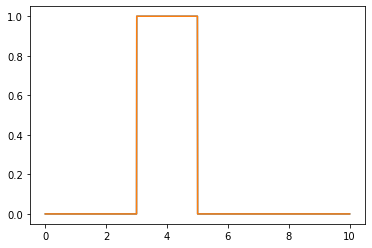

In [5]:
#functions

#PULSE SPECIFICATIONS
#get params AQiPT object from dictionary
params = aqipt.general_params({'sampling':3030, 'bitdepth':16, 'time_dyn':1}); 

#params for square pulse
args_lst = {'amp': 1, 't_o':4., 'width': 1, 'tp_window': 10}
tp = np.linspace(0, args_lst['tp_window'], params.sampling);
squarePulse, plot = aqipt.function(tp, args_lst).step(plotON=False)

#params for gaussian pulse
args_lst = {'amp': 1, 't_o':4., 'width': 1, 'tp_window': 10}
tp = np.linspace(0, args_lst['tp_window'], params.sampling);
gaussianPulse, plot = aqipt.function(tp, args_lst).step(plotON=False)

#points for the f(t)
x_points = [ 0, 1, 2, 3, 4, 5]
y_points = [12,14,22,39,58,77]

#functions for f(t)
function_1 = np.cos(10*tau[1]) + 1; #trigonometric function
function_2 = np.asarray(y_points, dtype=np.float64); #spline from points function
function_3 = np.repeat([0., 1., 0.], 101); #easy square function using numpy
function_4 = np.array(squarePulse, dtype=np.float); #square pulse using AQiPT
function_5 = gaussian(tp, mu=5, sig=0.1); #gaussian pulse

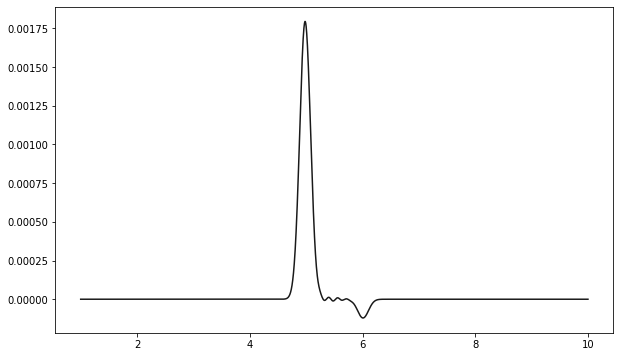

In [6]:
#convolution 

function = function_5; #select f(t-t')
kernel = kernel_3; #select k(t')
resultR = convolution1D(function, np.real(kernel)); #integral{f(t-t')k(t')dt'}

#ploting

plt.figure(figsize=(10,6))
# plt.plot(np.linspace(1,10,len(function)), function, color='red')
# plt.plot(tau[0], kernel, color='blue')
plt.plot(np.linspace(1,10,len(resultR)), resultR, color='black', alpha=0.9)



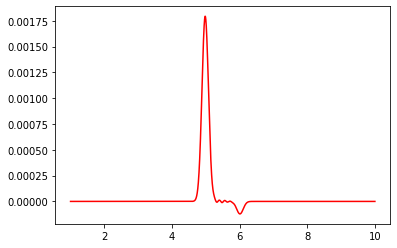

In [7]:
#with scipy
Conv= np.convolve(function, np.real(kernel), mode='valid')*(1/kernel.size)
plt.plot(np.linspace(1,10,len(Conv)), Conv, color='red')


<div class="alert alert-block alert-danger">

**Method** : full transfer matrix approach considering the response time behaviour and multi-demensional tensor including all cross-correlation of experimental params

In [ ]:
#domaing values for convolution
tau = [np.linspace(0,20,101)]

#kernel
kernel = [voigt_f, signal.unit_impulse(int(len(tau[0])), 1), gaussianSpectralResponse(tau, 10, 1, 1)]

#function x(t)
# function = np.cos(1*tau[0] + np.pi/3)+1
function = np.repeat([0., 1., 0.], 100)

resultR = convolution1D(function, np.real(kernel[1]))
resultI = convolution1D(function, np.imag(kernel[1]))


plt.plot(tau[0], kernel[1], color='red', alpha=0.3)
plt.plot(function, color='green', alpha=0.3)

plt.plot(resultR, color='black', alpha=0.9)
plt.plot(resultI, color='gray', alpha=0.9)

In [ ]:
-build kernels
-build dependency functions
-build tensor
-do product
-reconstruct signal
-plot signal and optical outcome


In [ ]:
def setKernel(kname:str, args:dict):

def setFunction(fname:str, args:dict):
    
def setTransferTensor(inParams, outParams,)

---

In [ ]:
->"Hardware-aware pulse optimized quantum gate for Rydberg qubits in dissipative environments"
    -hardware emulation
    -dynamics simulation 
    -quantum optimal control
    -quantum gate
    -new qubit encoding in work (rr-qubits)
    -quantum error correction (application)
    
Candidates for papers:
    
    ->"Hardware-aware pulse optimized quantum gate for Rydberg qubits in dissipative environments"
    ->"Demostration of a gate toolbox for Rydberg qubits"
    ->"Scaling coherence to large arrays of Rydberg qubits"
    ->"AQiPT: Atomic Quantum information Processing Toolbox framework for quantum engineering."
    ->"Using multipartite entanglement of self-protected dissipatve qubits for quatum error correction"

In [ ]:
#09-09-2021


In [2]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt



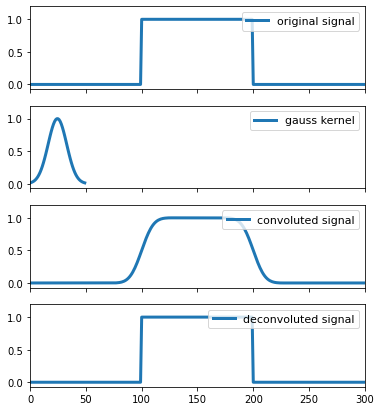

In [10]:
signal = np.repeat([0., 1., 0.], 100)
gauss = np.exp(-( (np.linspace(0,50)-25.)/float(12))**2 )

#convolution
filtered = np.convolve(signal, gauss, mode='same') 

#deconvolution
deconv,  _ = scipy.signal.deconvolve( filtered, gauss )

n = len(signal)-len(gauss)+1
s = int((len(signal)-n)/2)

deconv_res = np.zeros(len(signal))
deconv_res[int(s):int(len(signal)-s-1)] = deconv
deconv = deconv_res

#plot
fig , ax = plt.subplots(nrows=4, figsize=(6,7))

ax[0].plot(signal, label="original signal",     lw=3 ) 
ax[1].plot(gauss, label="gauss kernel", lw=3 )
ax[2].plot(filtered/np.sum(gauss), label="convoluted signal" ,  lw=3 )
ax[3].plot(deconv, label="deconvoluted signal", lw=3 ) 

for i in range(len(ax)):
    ax[i].set_xlim([0, len(signal)])
    ax[i].set_ylim([-0.07, 1.2])
    ax[i].legend(loc=1, fontsize=11)
    if i != len(ax)-1 :
        ax[i].set_xticklabels([])


In [5]:
s

24.5